# **IMPORTS**

In [ ]:
input_shape = (590,590)

import tensorflow as tf
from tqdm import tqdm
from skimage.transform import resize
import cv2
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import EfficientNetB0
from keras import layers, metrics, optimizers, losses
from keras.layers import Input, Flatten, Dense, Lambda, Layer
from keras.models import load_model, Model
from keras import Sequential
from tensorflow.keras.preprocessing import image as im
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import zipfile
from keras.preprocessing.image import ImageDataGenerator

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **Method definition**

In [2]:
from PIL import Image
import os
from sklearn.metrics import silhouette_score, silhouette_samples

# given an array of indexes, the method plots the image of each index 
# from the folder path. Eventually it splits the images in rows of 10 plots.
def plot_images_from_folder(index_array, image_folder_path, cluster_labels=None):
    # Get the list of image files in the folder
    image_files = os.listdir(image_folder_path)

    num_images = len(index_array)
    num_cols = 10
    num_rows = num_images // num_cols + int(num_images % num_cols > 0)
    
    # Create a subplot with a 2D grid of num_rows rows and 10 columns
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))
    
    iteration = 0
    for i, ax in zip(index_array, axs.flatten()):            
        if iteration < num_images:
            # Load the image using the PIL library
            image_path = os.path.join(image_folder_path, image_files[i])
            image = Image.open(image_path)

            # Convert the image to a NumPy array
            image_array = np.asarray(image)

            # Plot the image using Matplotlib
            ax.imshow(image_array, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')           

        # Set the title of the subplot to the cluster number
        if cluster_labels is not None:
            cluster_num = cluster_labels[i]
            ax.set_title(f"Cluster {cluster_num}")

        iteration += 1
    plt.show()

    
# Resizes the image to 224x224 and makes it B&W
def less_invasive_preprocessing(input_folder, output_folder):
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all the files in the input folder
    for filename in tqdm(os.listdir(input_folder)):
        # Read the input image
        input_path = os.path.join(input_folder, filename)
        img = cv2.imread(input_path)

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the contours in the binary image
        resized_img = cv2.resize(gray, (224, 224))

        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, resized_img)
    

# For each image in the input folder, it applies an object detection algorithm
# in order to make the black part of the image the main focus. Moreover, 
# every part of the image that is not completely black becomes white.
def create_minimal_dataset(input_folder, output_folder):
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all the files in the input folder
    for filename in tqdm(os.listdir(input_folder)):
        # Read the input image
        input_path = os.path.join(input_folder, filename)
        img = cv2.imread(input_path)
        img[img < 130] = 0

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to create a binary image
        thresh_value = 30  # threshold value
        max_value = 255  # maximum pixel value
        thresh_type = cv2.THRESH_BINARY  # threshold type
        _, thresh = cv2.threshold(gray, thresh_value, max_value, thresh_type)
        
        thresh = 255 - thresh
        # print(input_path)

        # Find the contours in the binary image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) != 0:

            # Find the minimum and maximum x and y coordinates of all the contours
            min_x = min([c[:, 0, 0].min() for c in contours])
            max_x = max([c[:, 0, 0].max() for c in contours])
            min_y = min([c[:, 0, 1].min() for c in contours])
            max_y = max([c[:, 0, 1].max() for c in contours])

            # Define the bounding box
            x, y, w, h = min_x, min_y, max_x - min_x, max_y - min_y

            # Determine the size of the square to crop
            crop_size = max(w, h)

            # Determine the center of the bounding box
            cx, cy = x + w // 2, y + h // 2
            
            if crop_size == 1:
                crop_img = img[cx, cy]

            else:
                # Crop the image to a square with the determined size
                move_size = min(crop_size//2 + 3, 294)
                # Calculate the bounds for cropping
                x1 = max(cx - move_size, 0)
                x2 = min(cx + move_size, 590)
                y1 = max(cy - move_size, 0)
                y2 = min(cy + move_size, 590)

                # Crop the image using the bounds
                crop_img = img[x1:x2, y1:y2]
            # Convert non-black pixels to white
            crop_img[crop_img > 130] = 255

            # Resize the cropped image to 224x224
            resized_img = cv2.resize(crop_img, (224, 224))

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_img)
            
        else:
            # Convert non-black pixels to white
            img[img != 0] = 255

            # Resize the cropped image to 224x224
            resized_img = cv2.resize(img, (224, 224))

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_img)
            

def zip_file(folder_to_zip, zip_save_folder):
    folder_name = os.path.basename(folder_to_zip)

    # Set the name of the zip file
    zip_filename = folder_name + ".zip"

    # Create a ZipFile object with the name and mode
    zip_file = zipfile.ZipFile(os.path.join(zip_save_folder, zip_filename), 'w', zipfile.ZIP_DEFLATED)

    # Iterate over the files in the folder and add them to the zip file
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            zip_file.write(os.path.join(root, file))

    # Close the zip file
    zip_file.close()

    
def create_vgg_model(layer='fc2'):
    base_model = VGG16(weights="imagenet", include_top=True)
    base_model.trainable = False
    model = Model(inputs=base_model.input,
                outputs=base_model.get_layer(layer).output)
    return model


def extract_features_vgg(path_to_files, model):
    features_map = []
    files = [file for file in os.listdir(path_to_files)]
    for file in tqdm(files):
        img = cv2.imread(path_to_files+file) #img is reshaped to better fit the model    
        imgp = preprocess_input(img)
        features = model.predict(imgp[None, ...], verbose=0) #predict requires [None, ...]
        features_map.append(features)
    return features_map


# Applies HDBScan to a dataset X and plots the silhouette score of each cluster
def apply_hdbscan(X, size):
    # Set up the HDBSCAN model with the desired parameters
    min_cluster_size = size
    min_samples = 1
    metric = 'euclidean'
    alpha = 1.0
    cluster_selection_method = 'eom'

    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        alpha=alpha,
        cluster_selection_method=cluster_selection_method
    )

    # Fit the model to the data with a progress bar
    hdbscan_cluster.fit(X)
        
    labels = hdbscan_cluster.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = np.sum(labels == -1)

    # Print the number of clusters and outliers
    print('Estimated number of clusters: %d' % n_clusters)
    print('Estimated number of outliers: %d' % n_outliers)
    
    # Compute silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette scores
    fig, ax = plt.subplots()
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate silhouette scores for samples in i-th cluster
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title("Silhouette plot for the HDBSCAN clustering")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    return labels


# Prints and returns the first ten indices of each cluster
def indices_to_plot(labels):
    # Group keys by cluster label
    clustered_keys = {}
    for i, label in enumerate(labels):
        if label != -1:
            key = i
            if label not in clustered_keys:
                clustered_keys[label] = []
            clustered_keys[label].append(key)

    indices = []
    # Print the first 10 keys of each cluster
    for label, keys in clustered_keys.items():
        print(f"Cluster {label}: {len(keys)} images")
        counter = 0
        for key in keys:
            # print(key)
            indices.append(key)
            counter += 1
            if counter == 10:
                break 
    return indices


# applies hdbscan and plots 10 images of each cluster
def perform_and_plot_HDBSCAN(dataset, min_size, origin_path):
    labels = apply_hdbscan(dataset, min_size)
    indices = indices_to_plot(labels)
    plot_images_from_folder(indices, origin_path)

In [ ]:
# INSTALLATION AND DOWNLOAD OF THE DATASET

!conda install -y gdown
!gdown --id 1FfIPKKRCspPwqvDgxO1_3tsXD2r0UeWT

In [ ]:
os.makedirs('/kaggle/working/minimal_dataset')
!unzip "/kaggle/working/mini_dataset.zip"

100%|██████████| 46335/46335 [06:15<00:00, 123.45it/s]


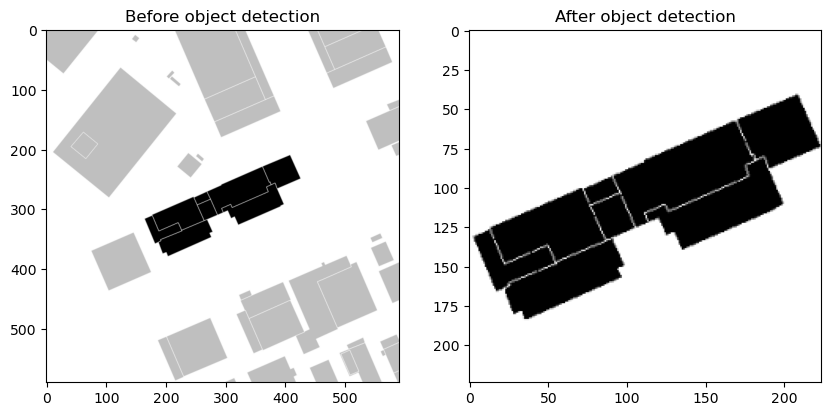

In [5]:
#
# CREATION OF A NEW DATASET WHERE THE BUILDING IN BLACK IS ZOOMED IN AND THE MAIN 
# FOCUS OF THE IMAGE. THIS IS A SORT OF OBJECT DETECTION I CREATED SPECIFICALLY 
# FOR THIS TASK.
#
create_minimal_dataset('/kaggle/working/mini_dataset', '/kaggle/working/minimal_dataset')


# Plot the two images side by side
img1 = mpimg.imread('/kaggle/working/mini_dataset/output_15.png')
img2 = mpimg.imread('/kaggle/working/minimal_dataset/output_15.png')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1)
ax[0].set_title('Before object detection')
ax[1].imshow(img2)
ax[1].set_title('After object detection')
plt.show()

In [ ]:
!pip install hdbscan
import hdbscan

In [7]:
model = create_vgg_model()

553467096/553467096 [==============================] - 2s 0us/step


# **WORKING ON THE BUILDINGS DATASET**

In [ ]:
# EXTRACTION OF THE MAIN FEATURES OF THE MINIMAL DATASET THROUGH VGG16
extracted = extract_features_vgg('/kaggle/working/minimal_dataset/', model)
X = np.squeeze(np.array(extracted))
gc.collect()

Estimated number of clusters: 7
Estimated number of outliers: 7723


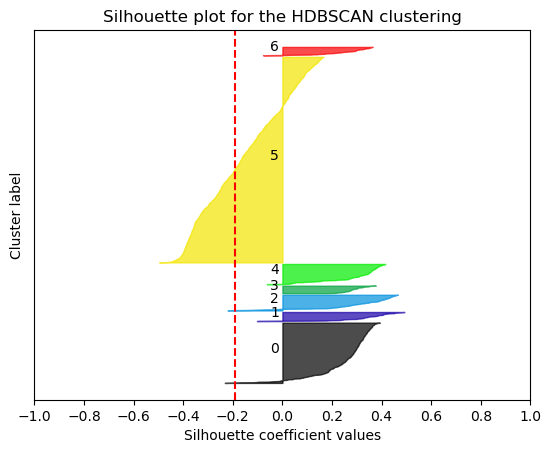

Cluster 2: 110 images
Cluster 5: 1430 images
Cluster 4: 141 images
Cluster 0: 420 images
Cluster 3: 53 images
Cluster 6: 59 images
Cluster 1: 64 images


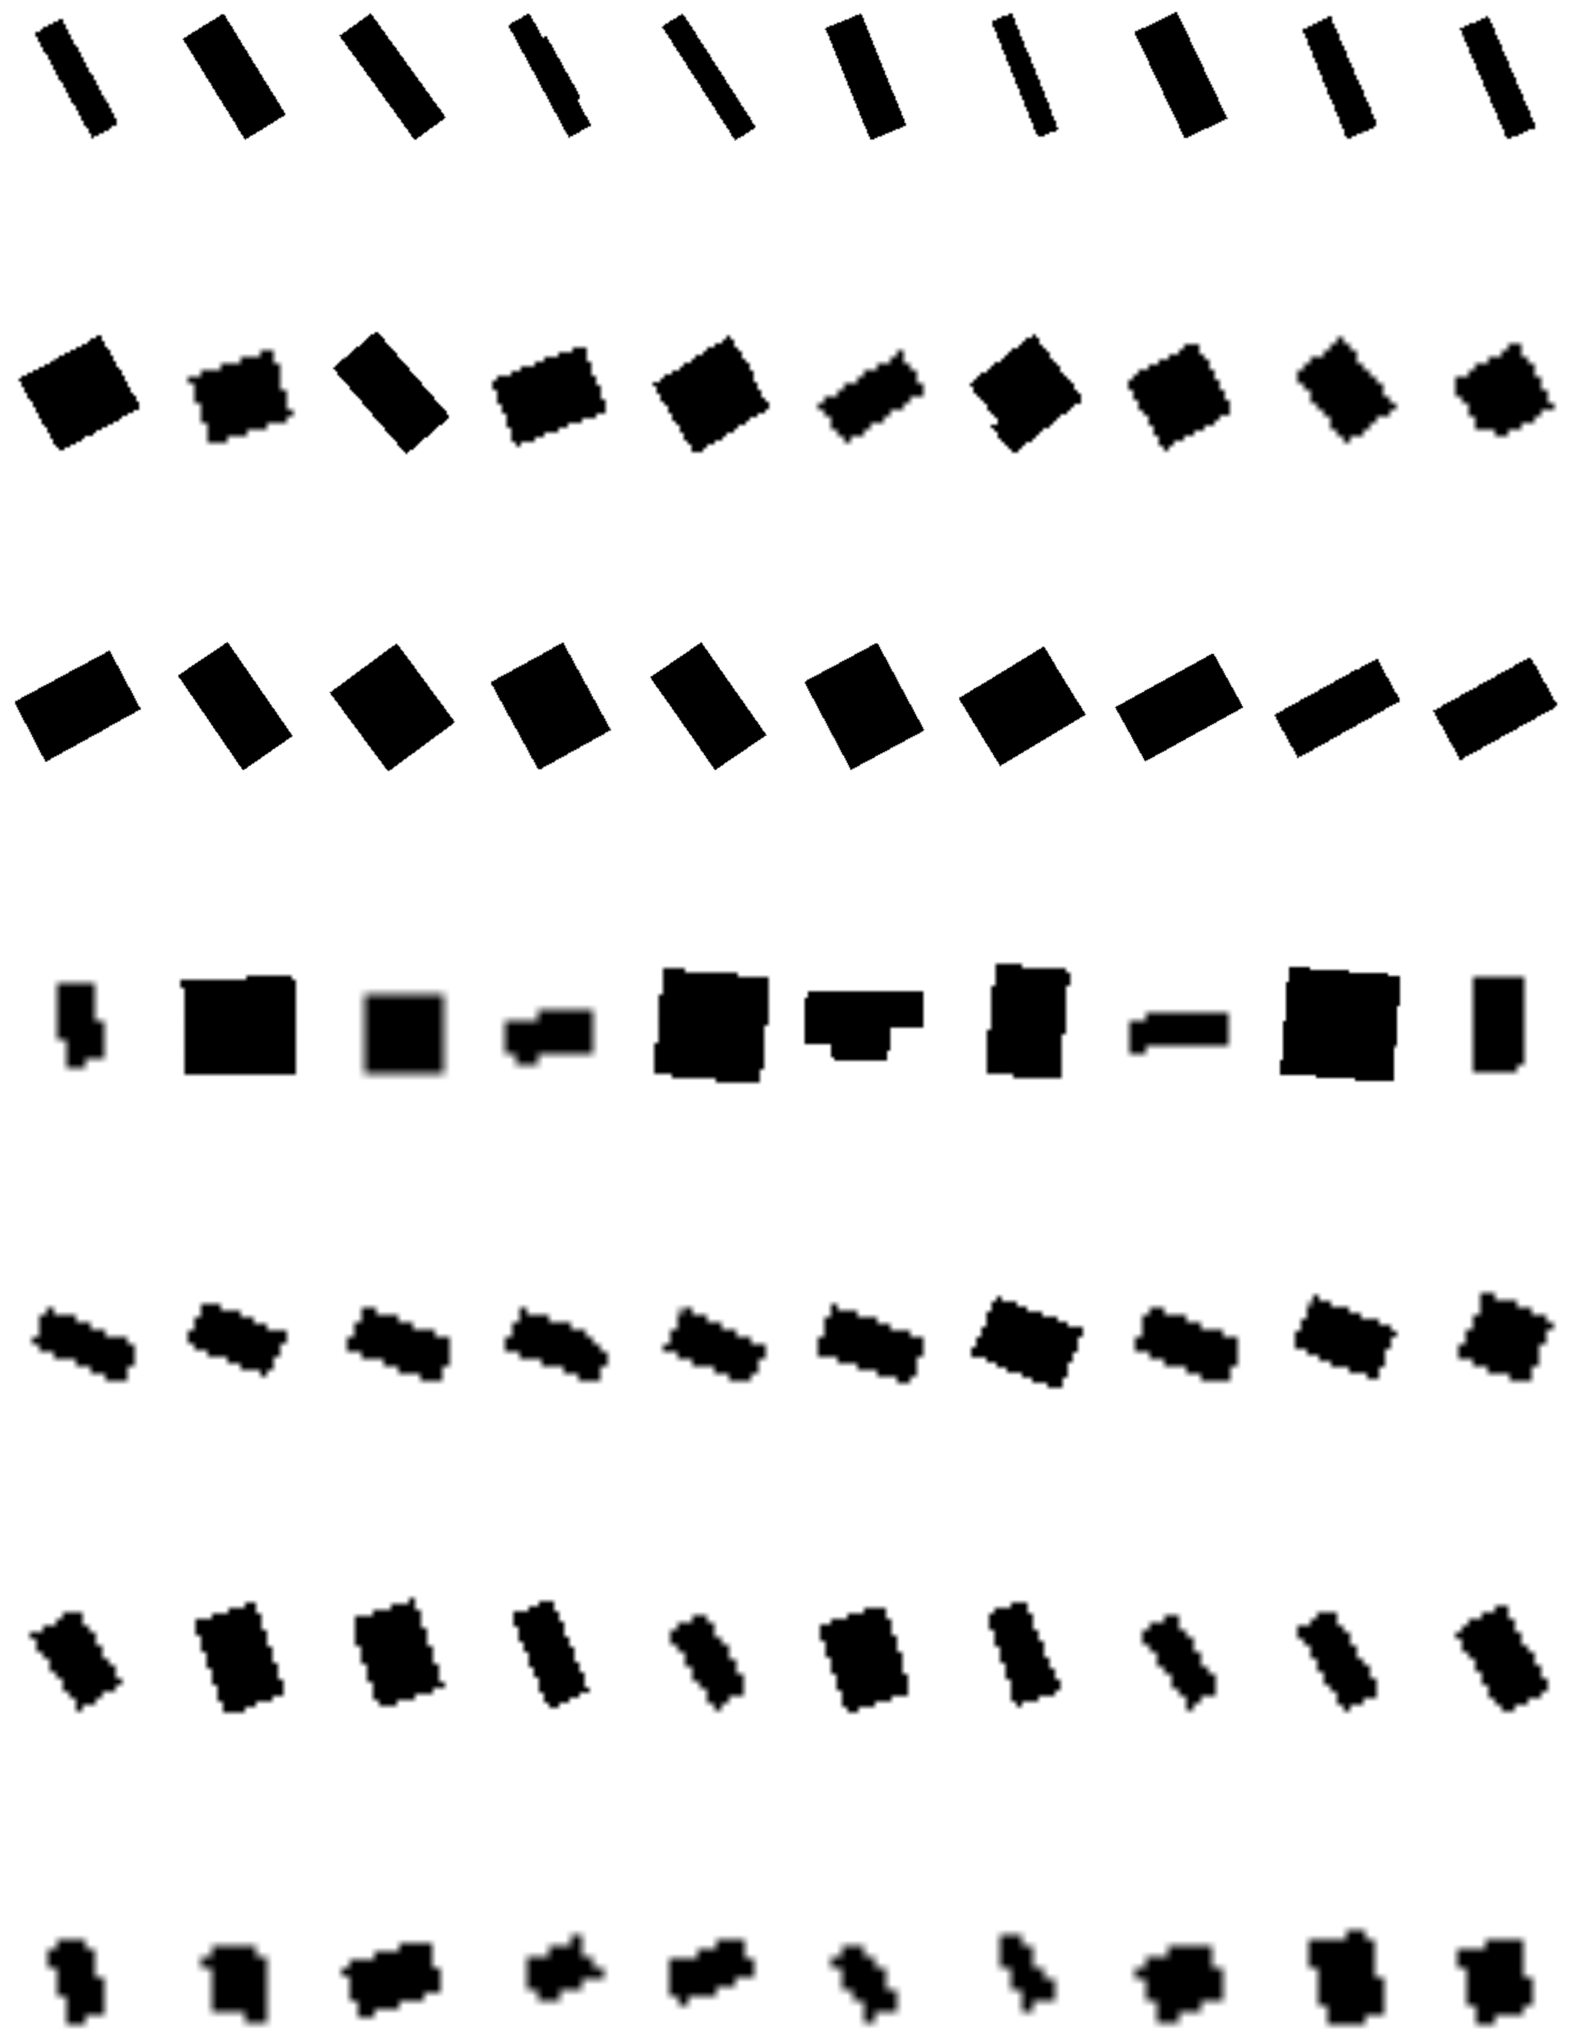

In [12]:
# HDBSCAN APPLICATION AND PLOT OF A MINIBATCH OF THE RESULTS
perform_and_plot_HDBSCAN(X, 50, '/kaggle/working/minimal_dataset/')

# **WORKING ON THE LETTERS DATASET**

In [4]:
# Define the letters to use and the number of samples to select for each letter
letters_used = ['A', 'B', 'C', 'E', 'F', 'H', 'I', 'L', 'O', 'P', 'S', 'T', 'U', 'V']
num_samples = 500

# Load the CSV file into a pandas dataframe
df = pd.read_csv('/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv')

# Filter the rows where the label column is in letters_used
df_filtered = df[df['labels'].isin(letters_used)]

# Group the filtered dataframe by the 'labels' column and select the first num_samples rows of each group
df_limited = df_filtered.groupby('labels').head(num_samples)

# Extract the image and label columns as NumPy arrays
y = np.array(df_limited['labels'].tolist())

# Resize the images to (224, 224) and store them in a 3D array
X_224 = np.empty((len(df_limited), 224, 224), dtype=np.float32)
for i in range(len(df_limited)):
    x_2d = (255 - df_limited.iloc[i, 2:].values.reshape((28, 28))).astype(np.float32)
    X_224[i] = resize(x_2d, (224, 224), anti_aliasing=True)

print(X_224.shape)

# Create a directory to store the minimal letters dataset if it does not exist
dir_path = '/kaggle/working/minimal_letters'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# loop over the images and save them in the new folder
for i, img in enumerate(X_224):
    file_path = os.path.join(dir_path, f"image_{i}.png")
    cv2.imwrite(file_path, img)

(7000, 224, 224)


In [7]:
less_invasive_preprocessing('/kaggle/working/minimal_letters/', '/kaggle/working/new_miniletters')

100%|██████████| 7000/7000 [00:06<00:00, 1066.79it/s]


In [8]:
# FEATURE EXTRACTION ON THE LETTERS DATASET
extracted_letters = extract_features_vgg('/kaggle/working/new_miniletters/', model)
Xl = np.squeeze(np.array(extracted_letters))

100%|██████████| 7000/7000 [07:34<00:00, 15.42it/s]


Estimated number of clusters: 16
Estimated number of outliers: 2519


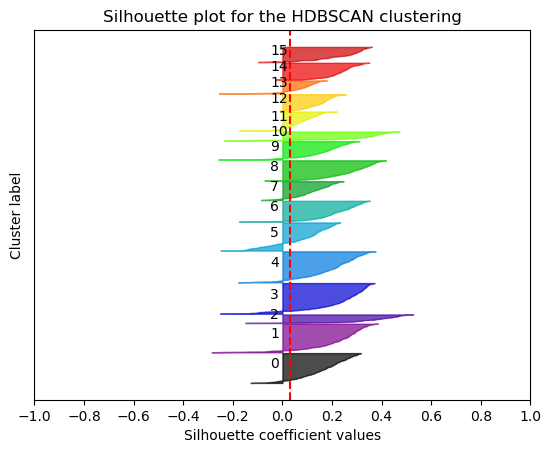

Cluster 8: 277 images
Cluster 14: 234 images
Cluster 7: 261 images
Cluster 5: 388 images
Cluster 1: 394 images
Cluster 0: 412 images
Cluster 4: 427 images
Cluster 3: 423 images
Cluster 10: 123 images
Cluster 6: 288 images
Cluster 13: 178 images
Cluster 9: 254 images
Cluster 2: 118 images
Cluster 11: 266 images
Cluster 15: 209 images
Cluster 12: 229 images


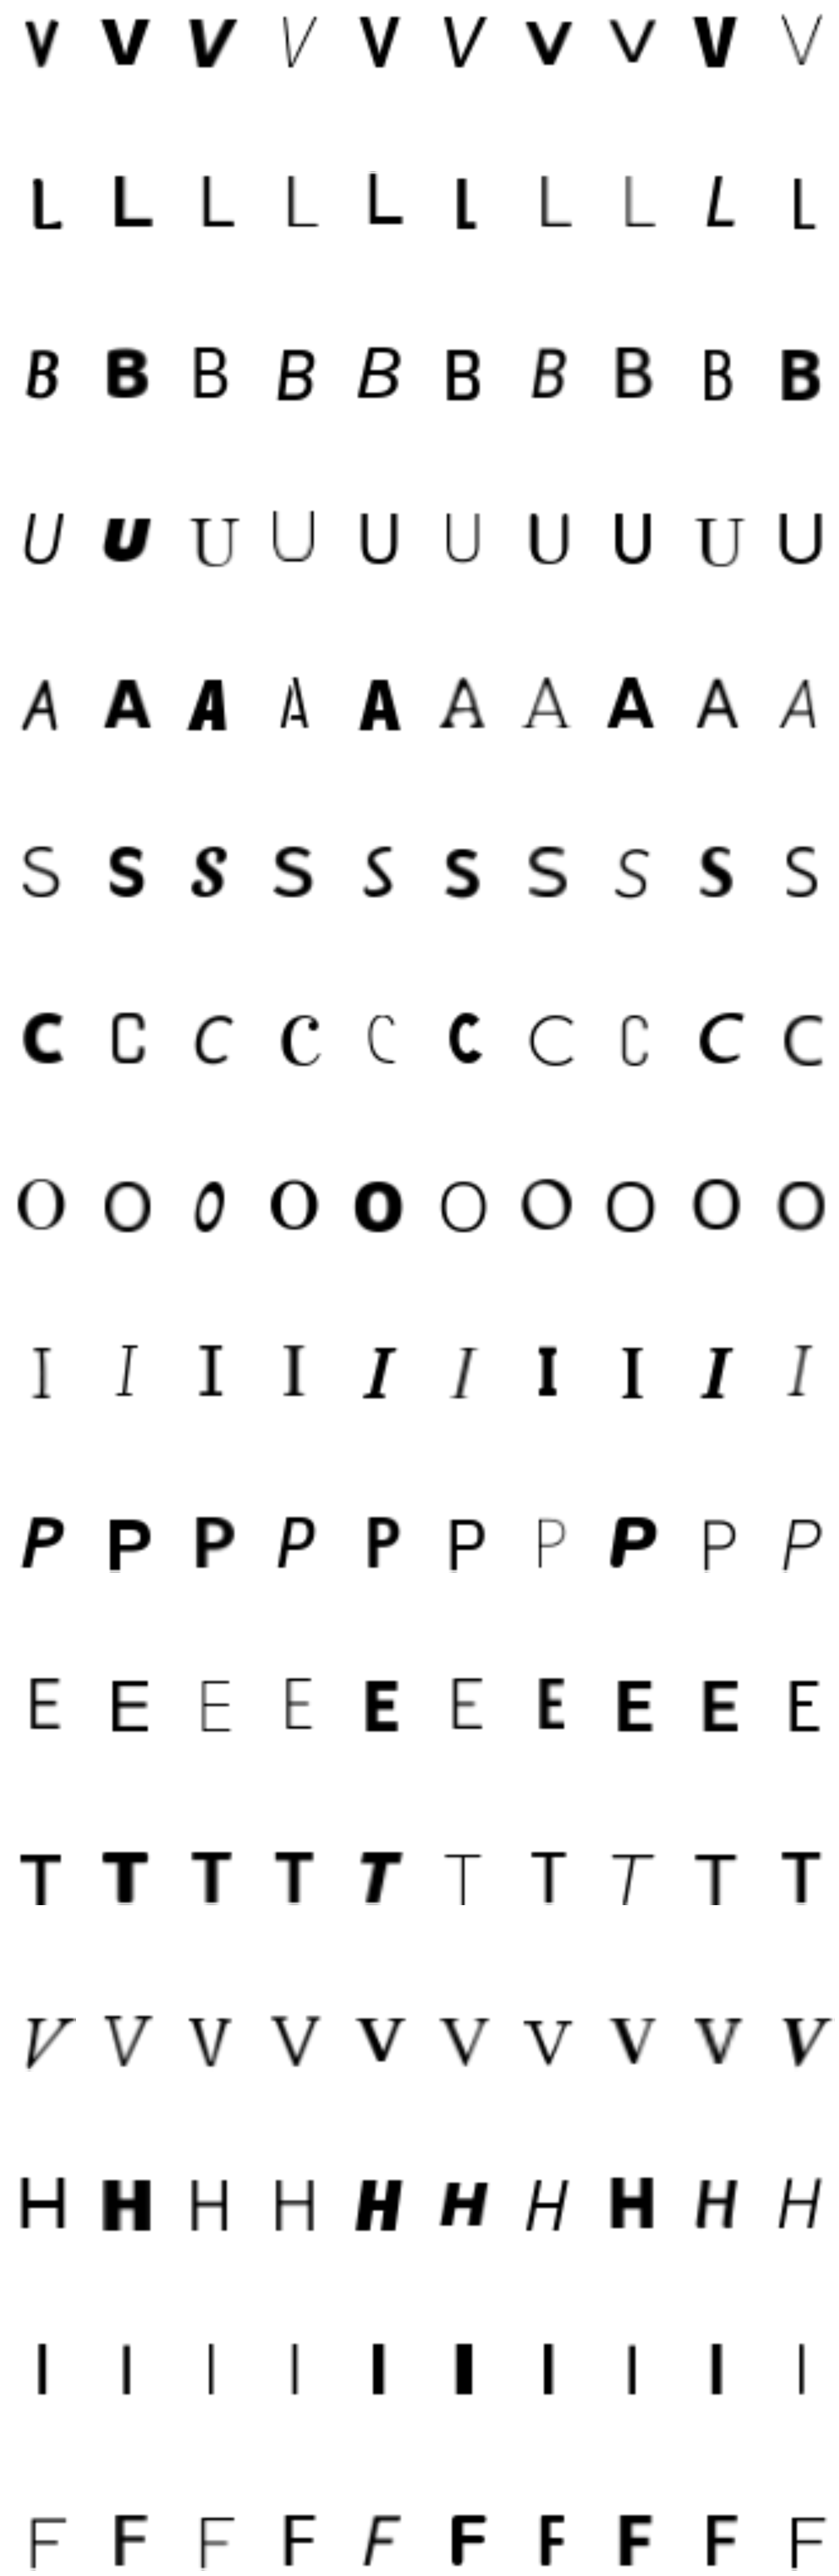

In [11]:
perform_and_plot_HDBSCAN(dataset=Xl, min_size=110, origin_path='/kaggle/working/new_miniletters/')

# **WORKING ON THE MIXED (LETTERS AND BUILDINGS) DATASET**

In [5]:
!gdown --id 1d6xEzxBZ2FMHgE3TbQa6MBPzEEahKU_w
os.makedirs('/kaggle/working/micromerged')
!unzip "/kaggle/working/micromerged.zip"

/bin/bash: gdown: command not found
unzip:  cannot find or open /kaggle/working/micromerged.zip, /kaggle/working/micromerged.zip.zip or /kaggle/working/micromerged.zip.ZIP.


In [15]:
extracted_mixed = extract_features_vgg('/kaggle/input/mixed-dataset/mixed_dataset/', model)
Xm = np.squeeze(np.array(extracted_mixed))

100%|██████████| 17000/17000 [20:31<00:00, 13.80it/s]


Estimated number of clusters: 12
Estimated number of outliers: 6507


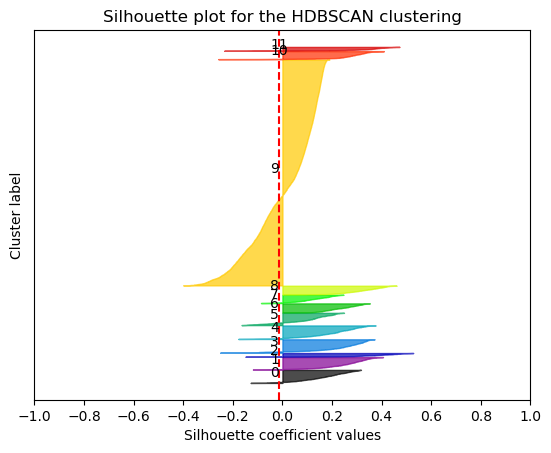

Cluster 9: 7128 images
Cluster 7: 261 images
Cluster 11: 123 images
Cluster 3: 423 images
Cluster 5: 388 images
Cluster 1: 394 images
Cluster 2: 118 images
Cluster 0: 412 images
Cluster 4: 427 images
Cluster 8: 277 images
Cluster 6: 288 images
Cluster 10: 254 images


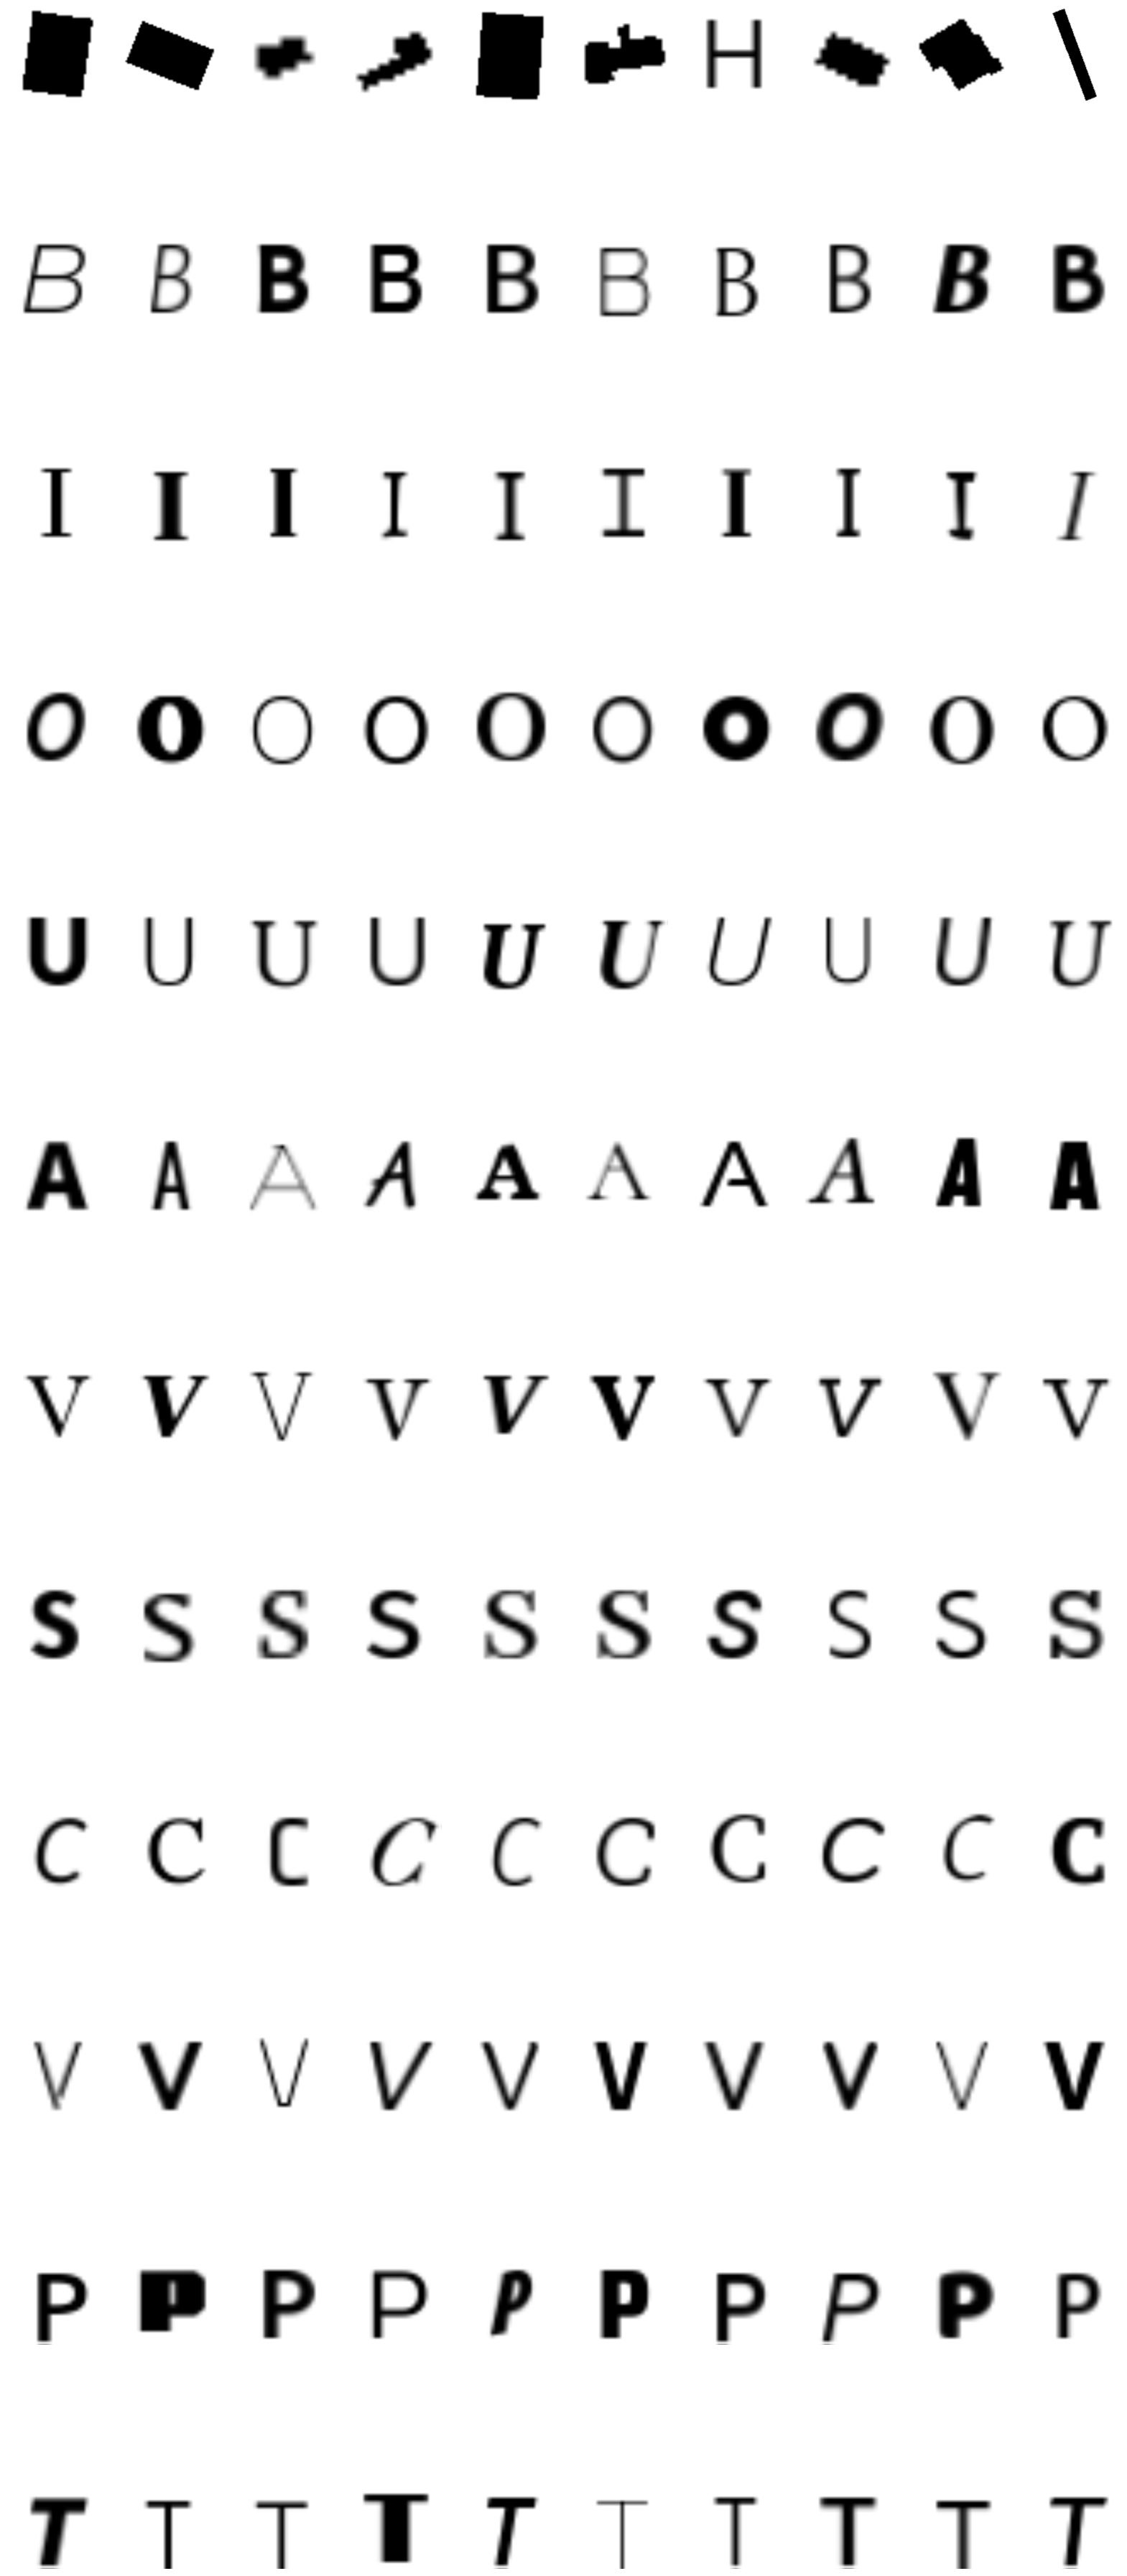

In [16]:
perform_and_plot_HDBSCAN(dataset=Xm, min_size=110, origin_path='/kaggle/input/mixed-dataset/mixed_dataset/')

# **AUTOENCODER PART**

In [9]:
# CREATE CLASS OF VARIATIONAL AUTOENCODER

class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
# Create a generator to feed the images one at a time to the model during training
def image_generator(images_input):
    while True:
        for i in range(0, len(images_input), vae_batch_size):
            batch_images = images_input[i:i + vae_batch_size]
            yield (batch_images, batch_images)


def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    total_loss = reconstruction_loss + kl_loss
    return total_loss

def extract_features_encoder(path_to_files, model,):
    features_map = []
    files = [file for file in os.listdir(path_to_files)]
    for file in tqdm(files):
        img = cv2.imread(path_to_files+file)
        gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
        gray_img = gray_img.astype(np.uint8)
        features = model.predict(gray_img[None, ...], verbose=0) #predict requires [None, ...]
        features_map.append(features[-1])
    return features_map

In [11]:
# Add custom layers to the Keras custom object scope
custom_objects = {"Sampling": Sampling}

# Load a model of encoder pretrained locally specifically for the buildings dataset
model = load_model('/kaggle/input/encoder-model/encoder_model.h5', custom_objects=custom_objects)
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 224, 224, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  320         ['reshape[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 32)   0           ['conv2d[0][0]']           

In [12]:
extracted_letters = extract_features_encoder('/kaggle/working/new_miniletters/', model)
Xl = np.squeeze(np.array(extracted_letters))

100%|██████████| 7000/7000 [07:23<00:00, 15.78it/s]


Estimated number of clusters: 12
Estimated number of outliers: 4573


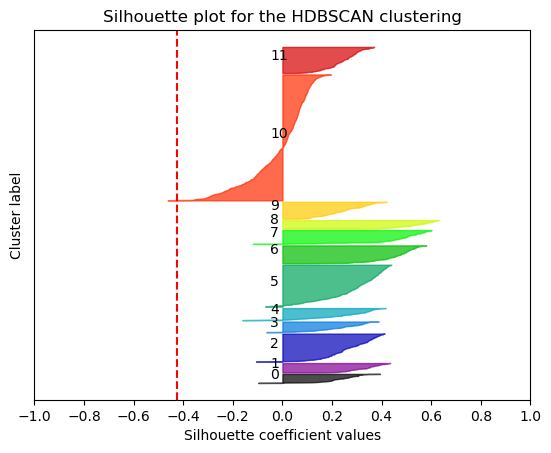

Cluster 10: 951 images
Cluster 1: 72 images
Cluster 2: 212 images
Cluster 0: 69 images
Cluster 6: 136 images
Cluster 11: 198 images
Cluster 8: 65 images
Cluster 5: 317 images
Cluster 3: 81 images
Cluster 4: 92 images
Cluster 7: 106 images
Cluster 9: 128 images


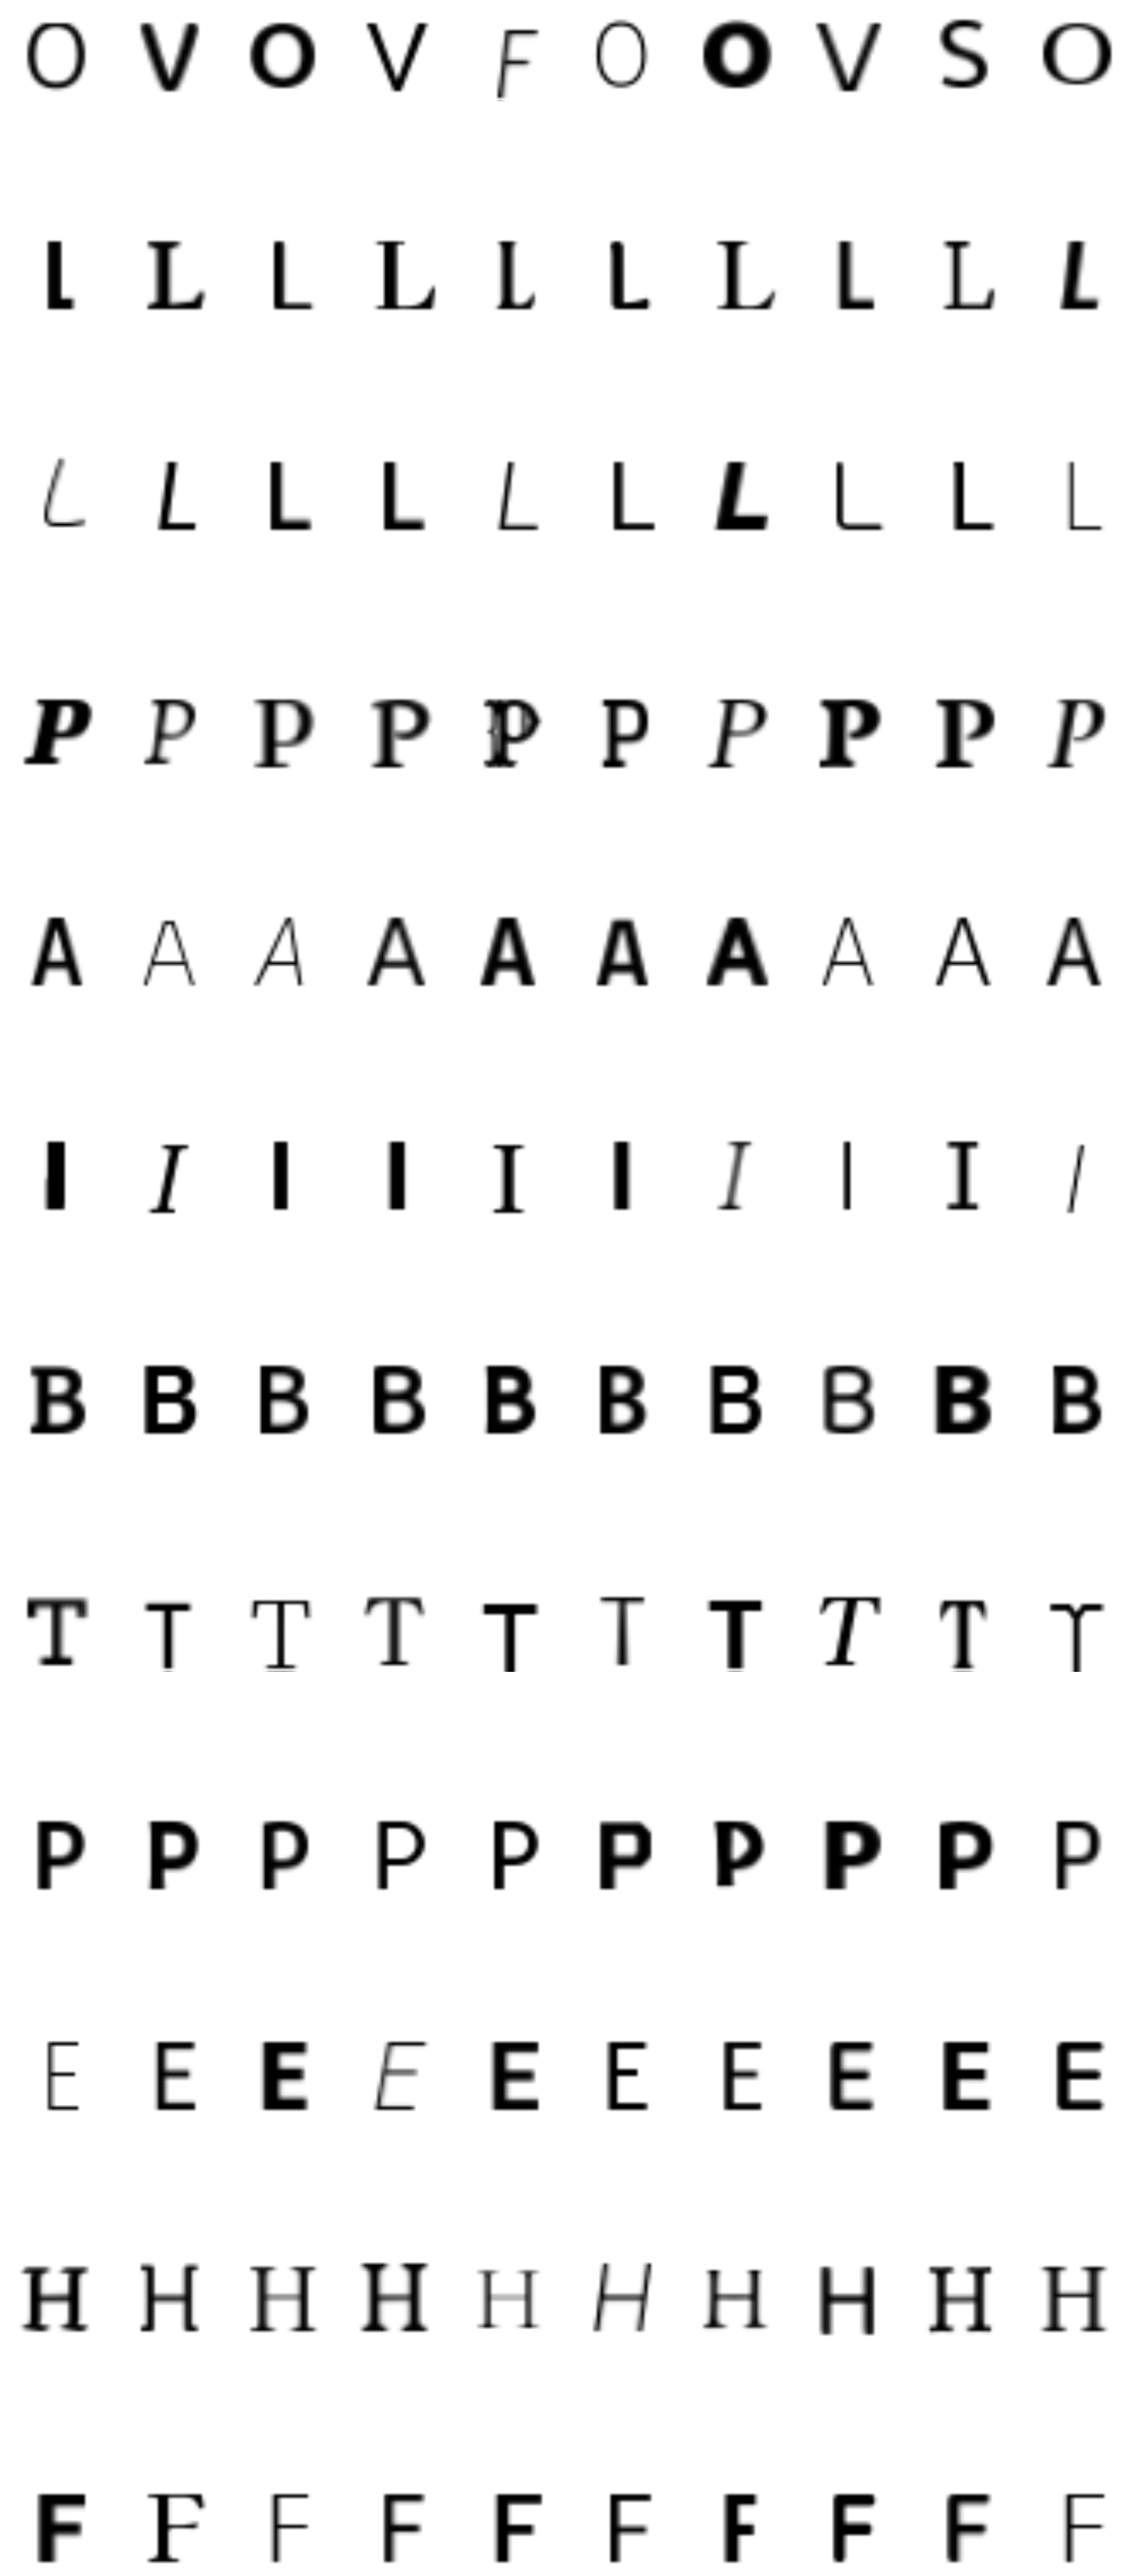

In [20]:
perform_and_plot_HDBSCAN(dataset=Xl, min_size=60, origin_path='/kaggle/working/new_miniletters/')

100%|██████████| 10000/10000 [09:14<00:00, 18.03it/s]


Estimated number of clusters: 7
Estimated number of outliers: 9055


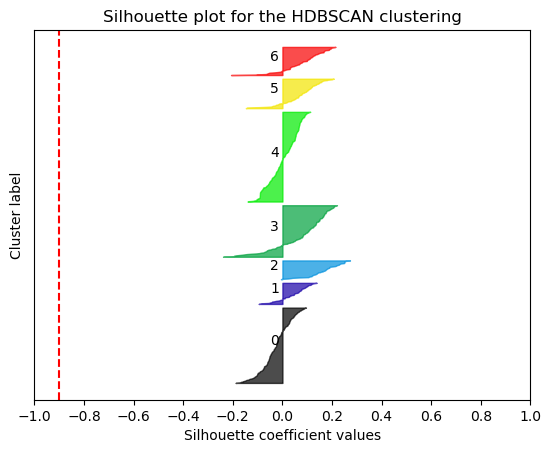

Cluster 4: 269 images
Cluster 5: 89 images
Cluster 3: 155 images
Cluster 6: 85 images
Cluster 1: 64 images
Cluster 0: 226 images
Cluster 2: 57 images


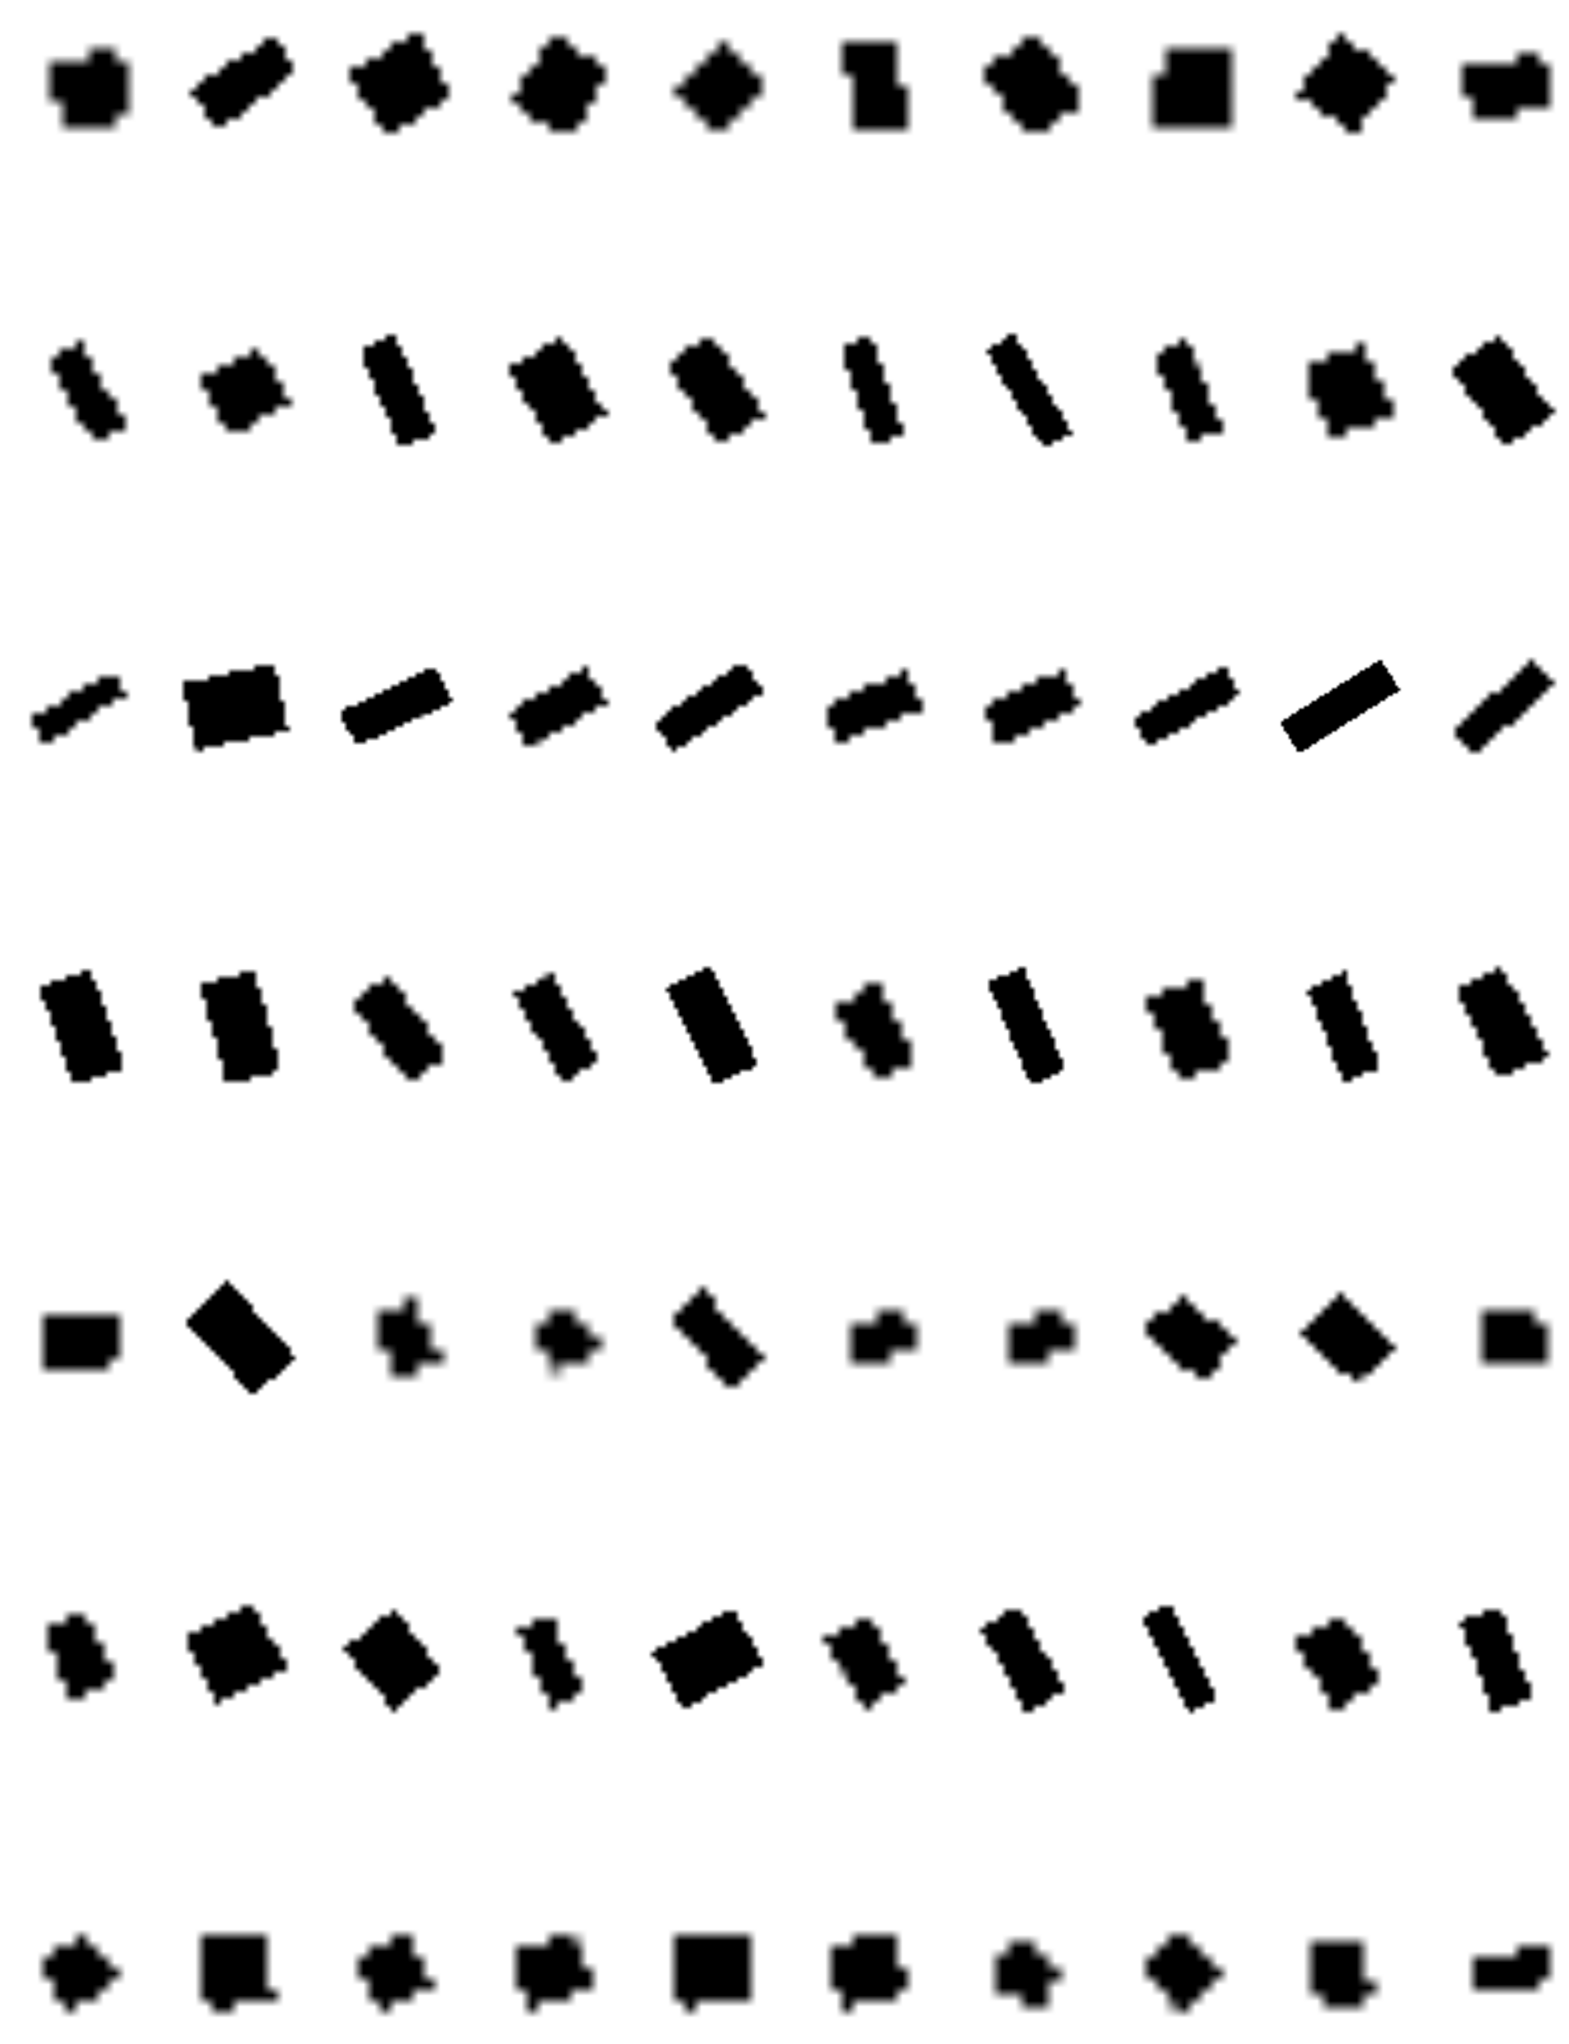

In [10]:
extracted = extract_features_encoder('/kaggle/working/minimal_dataset/', model)
X = np.squeeze(np.array(extracted))
perform_and_plot_HDBSCAN(X, 50, '/kaggle/working/minimal_dataset/')

100%|██████████| 17000/17000 [18:17<00:00, 15.48it/s]


Estimated number of clusters: 2
Estimated number of outliers: 9970


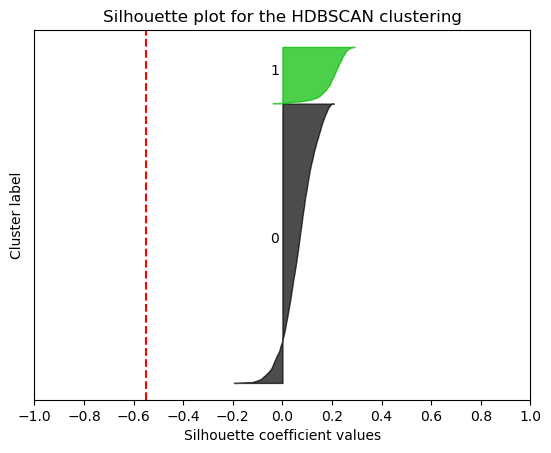

Cluster 1: 1178 images
Cluster 0: 5852 images


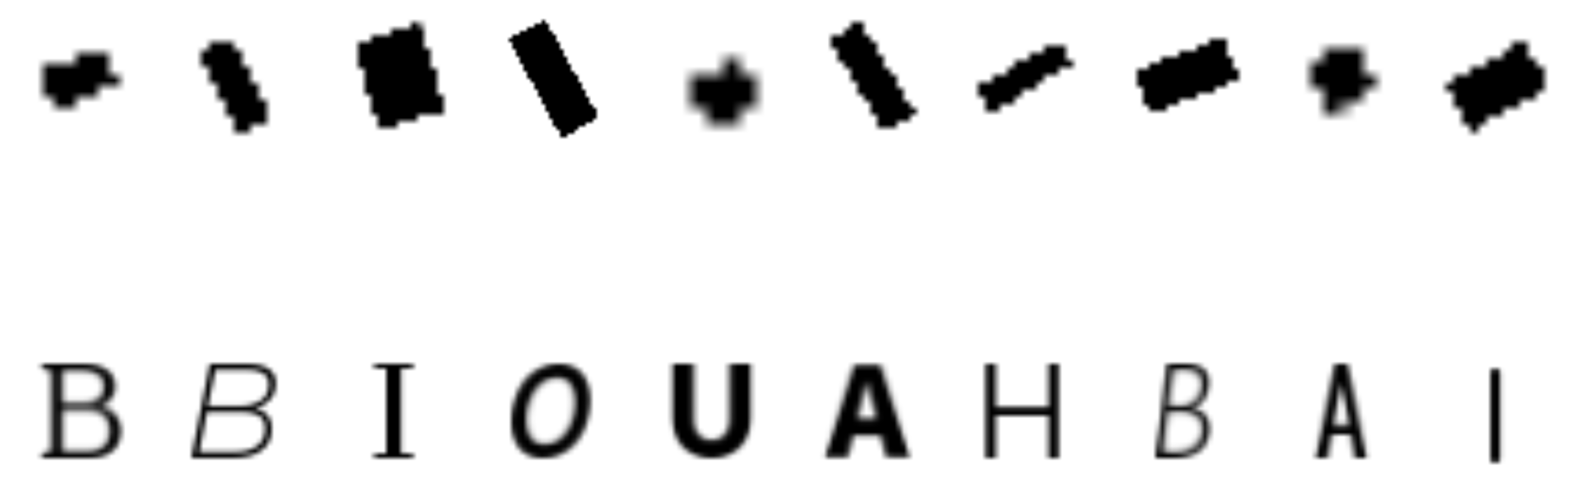

In [10]:
extracted_mixed = extract_features_encoder('/kaggle/input/mixed-dataset/mixed_dataset/', model)
Xm = np.squeeze(np.array(extracted_mixed))
perform_and_plot_HDBSCAN(dataset=Xm, min_size=110, origin_path='/kaggle/input/mixed-dataset/mixed_dataset/')

# **RATIONAL THINKING WITH A BALANCED DATASET**

I created a dataset composed only of the building whose shape are more frequent (square, long rectangle, L) and the algorithm is able to detect with a decent accuracy the difference between square and long rectangle shape. L's are not detected correctly because of how different the buildings are even if they share the shape. In the end, I think that the poor results of the methods applied before, is due to the fact that almost all the building have square or rectangle shape, so the ones with different shapes are not clustered correctly, and even adding letters to the dataset doesn't help much

100%|██████████| 150/150 [00:09<00:00, 15.04it/s]


Silhouette score: 0.060
Estimated number of clusters: 2
Estimated number of outliers: 88
Cluster 0: 25 images
Cluster 1: 37 images


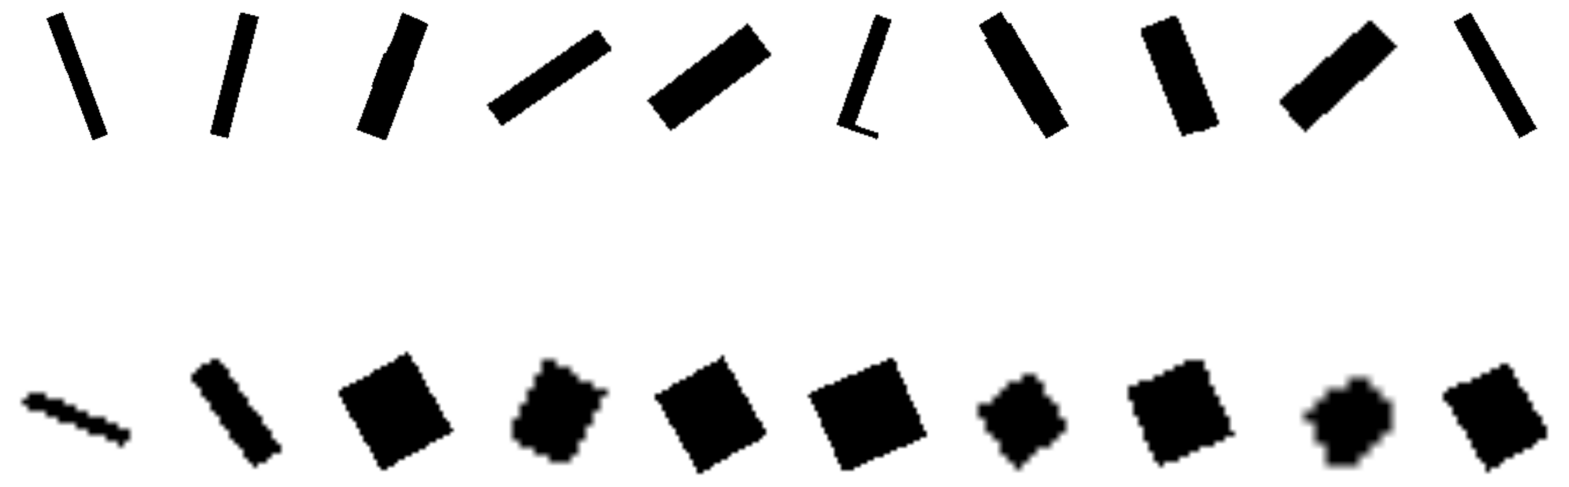

In [15]:
r_mixed = extract_features_vgg('/kaggle/input/rationallymixed/rationally mixed/', model)
Xr = np.squeeze(np.array(r_mixed))
perform_and_plot_HDBSCAN(dataset=Xr, min_size=23, origin_path='/kaggle/input/rationallymixed/rationally mixed/')

100%|██████████| 250/250 [00:17<00:00, 14.32it/s]


Silhouette score: 0.121
Estimated number of clusters: 3
Estimated number of outliers: 55
Cluster 1: 114 images
Cluster 2: 58 images
Cluster 0: 23 images


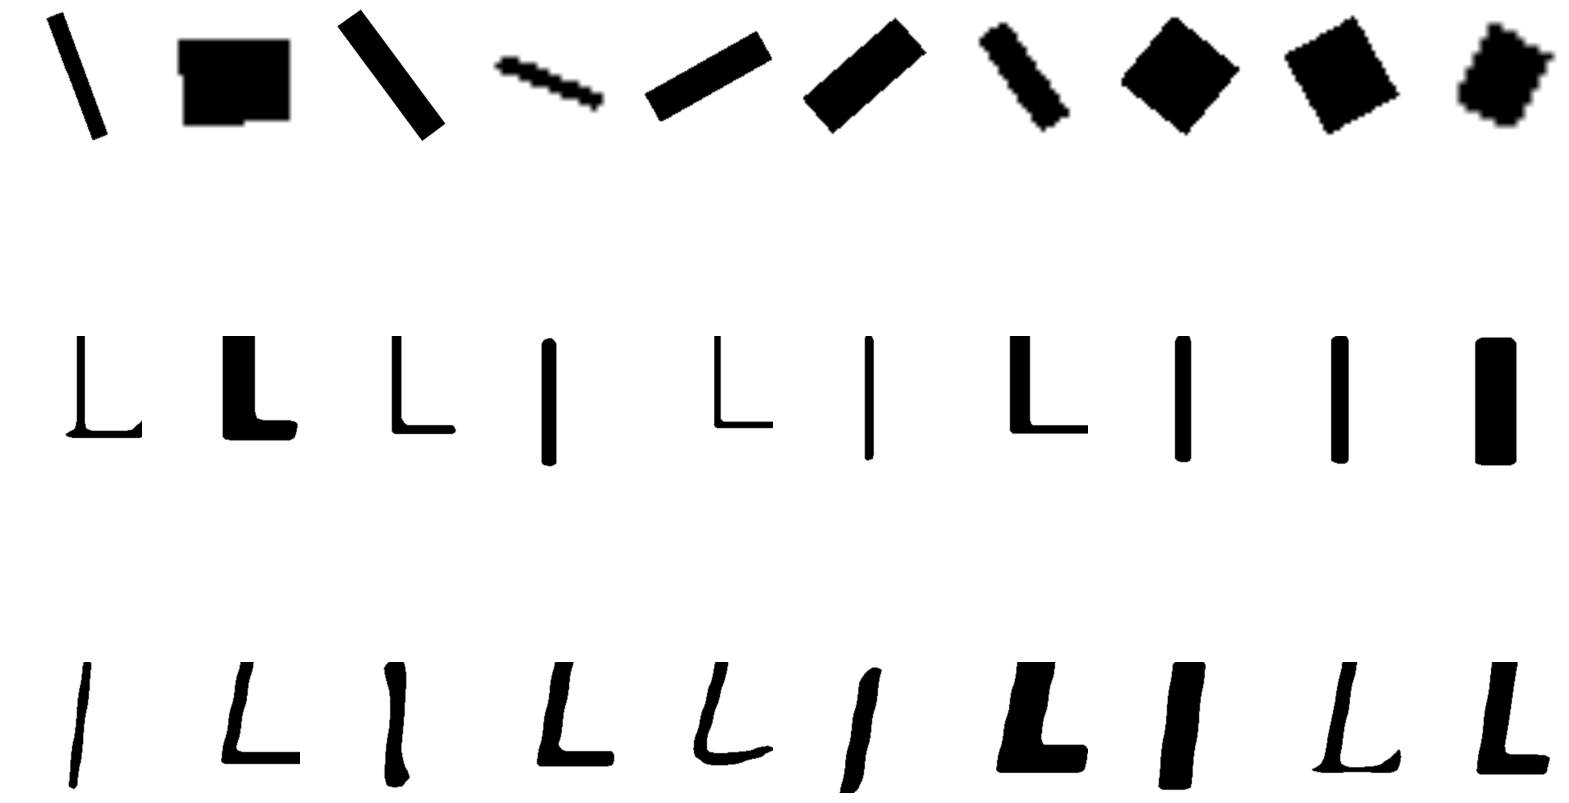

In [17]:
r_mixed = extract_features_vgg('/kaggle/input/rationally-letters/rationally w letters/', model)
Xr = np.squeeze(np.array(r_mixed))
perform_and_plot_HDBSCAN(dataset=Xr, min_size=23, origin_path='/kaggle/input/rationally-letters/rationally w letters/')